In [32]:
# Comprobar si nos encontramos en Google Colab o en el proyecto (Jupyter)
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# Importación de librerías 🐍

In [33]:
import os
import time
import random
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt




# Librería SpaCy para preprocesamiento de texto
import spacy
!python -m spacy download es_core_news_sm

# Manejo de emojis
!pip install emoji
import emoji

# Vectorización de texto
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Modelos clásicos de machine learning
from sklearn.naive_bayes import ComplementNB, BernoulliNB
from sklearn.svm import LinearSVC

# Métricas de evaluación
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Deep Learning y procesamiento de texto con Keras y TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Input,
    Embedding,
    Dense,
    Flatten,
    Conv1D,
    MaxPooling1D,
    Dropout,
    GlobalAveragePooling1D,
    BatchNormalization
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Guardar modelos ya entrenados
import pickle

if IN_COLAB:
    !git clone https://github.com/wrstdani/gia_pln1_practica.git
    !mv gia_pln1_practica/* .
    !rm -rf gia_pln1_practica
    !rm notebook.ipynb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 100.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Cloning into 'gia_pln1_practica'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 50 (delta 7), reused 47 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (50/50), 21.33 MiB | 26.31 MiB/s, done.
Resolving deltas: 100% (7/7), done.
mv: cannot move 'gia_pln1_practica/data' to './data': Directory not empty
mv: cannot move 'gia_pln1_practica/models' to './models': Directory not empty
mv: cannot move 'gia_pln1_practica/resources' to './resources': Directory not empty


# Clasificación de ideologías de tuits 🐦

## Carga de datos 💾

In [88]:
"""
- Definimos la ruta en que se encuentran nuestros datos y cargamos los DFs necesarios

"""
data_path = "data"  # Datos proporcionados y generados
data_generated_path = os.path.join(data_path, "generated")  # Datos generados
resources_generated_path = os.path.join("resources", "generated")  # Recursos (gráficos, PDFs, etc.)
models_path = os.path.join("models")  # Modelos preentrenados

embeddings_static_path = os.path.join(data_generated_path, "embeddings_static")  # Embeddings estáticos
if not os.path.exists(embeddings_static_path):
    os.makedirs(embeddings_static_path)

embeddings_fasttext_path = os.path.join(data_generated_path, "embeddings_fasttext")  # Embeddings estáticos
if not os.path.exists(embeddings_fasttext_path):
    os.makedirs(embeddings_fasttext_path)


embeddings_context_path = os.path.join(data_generated_path, "embeddings_context")  # Embeddings contextuales
if not os.path.exists(embeddings_context_path):
    os.makedirs(embeddings_context_path)

train_df = pd.read_csv(os.path.join(data_path, "train.csv"))  # Dataset de entrenamiento
dev_df = pd.read_csv(os.path.join(data_path, "development.csv"))  # Dataset de desarrollo (test)
test_df = pd.read_csv(os.path.join(data_path, "testCleaned.csv"))  # Dataset de entrenamiento


In [35]:
train_df.head()

,id,label,gender,profession,ideology_binary,ideology_multiclass,tweet
0,37732,@user239,female,politician,right,moderate_right,"@user, propuestas de futuro 💪#no tocar las ref..."
1,38447,@user13,female,journalist,left,left,@user @user Podemos entrar en bucle hasta el i...
2,10758,@user8,female,politician,left,moderate_left,👉🏻Como gallega me produce profunda decepción v...
3,33860,@user262,male,politician,right,right,"Y ahora, tras este raro de amable discusión so..."
4,11677,@user341,female,politician,right,right,1-No se trata de defender o no la labor de @us...


In [36]:
dev_df.head()

,id,label,gender,profession,ideology_binary,ideology_multiclass,tweet
0,14755,@user206,female,journalist,left,moderate_left,En unos minutos adelantaremos en @user imágene...
1,31904,@user137,female,politician,left,moderate_left,"Vacunar, vacunar y vacunar. Ese es el gran obj..."
2,45517,@user180,male,journalist,right,moderate_right,Me voy para @user. Hoy no hay programa pero es...
3,11015,@user290,male,politician,left,left,Vivimos en un país en el 12 mill y medio de pe...
4,25991,@user228,male,politician,right,moderate_right,En casa de la VP Rivera no les gusta q se habl...


In [90]:
"""
- Extraemos las etiquetas (labels) para la clasificación y los tuits
"""
labels = {
    "moderate_left": 0,
    "left": 1,
    "moderate_right": 2,
    "right": 3
}

print("- Etiquetas:")
print(f"    - Existen {len(labels)} clases:")
for l, i in labels.items():
    print(f"        - {l} -> {i}")

corpus_train = train_df["tweet"].tolist()
y_train = np.array([labels[l] for l in train_df["ideology_multiclass"]]).reshape(len(corpus_train), 1)
corpus_dev = dev_df["tweet"].tolist()
y_dev = np.array([labels[l] for l in dev_df["ideology_multiclass"]]).reshape(len(corpus_dev), 1)
corpus_test = dev_df["tweet"].tolist()

print("- Conjuntos de datos:")
print("    - Entrenamiento:")
print(f"        - {y_train.shape[0]} ejemplos.")
print("    - Desarrollo (Test):")
print(f"        - {y_dev.shape[0]} ejemplos.")


- Etiquetas:
    - Existen 4 clases:
        - moderate_left -> 0
        - left -> 1
        - moderate_right -> 2
        - right -> 3
- Conjuntos de datos:
    - Entrenamiento:
        - 28065 ejemplos.
    - Desarrollo (Test):
        - 4678 ejemplos.


## Visualización y preprocesamiento de los datos 🔍

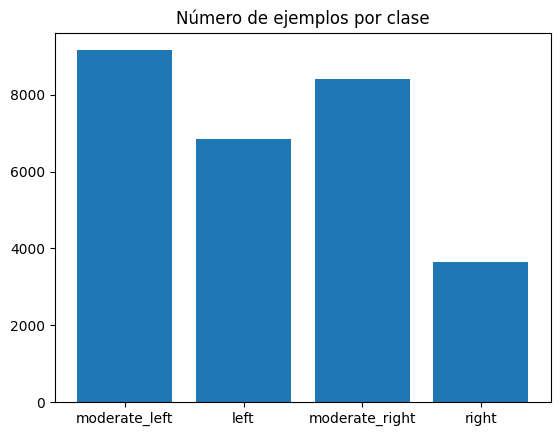

In [38]:
"""
- Número de ejemplos de cada clase
"""
filename = "train_classes_hist.png"
save_flag = True

classes, samples_per_class = np.unique(y_train, return_counts=True)
classes = [list(labels.keys())[c] for c in classes]

plt.figure()
plt.title("Número de ejemplos por clase")
plt.bar(classes, samples_per_class)
if save_flag:
    plt.savefig(os.path.join(resources_generated_path, filename))
plt.show()

- Como los textos proporcionados se encuentran escritos en español, utilizamos el modelo "es_core_news_sm" de SpaCy (https://spacy.io/models/es).

In [39]:
spacy_model = "es_core_news_sm"
nlp = spacy.load(spacy_model)

def preprocess_sent(model,
                    text,
                    lowercase=True,
                    remove_urls=True,
                    remove_punct=True,
                    remove_numbers=False,
                    remove_stopwords=True,
                    lemmatize=False,
                    remove_hashtags=True,
                    remove_mentions=True,
                    replace_emojis=True,
                    reduce_repeated_chars=True,
                    min_token_length=3):
    if not text:
        return ""

    t = text

    if lowercase:
        t = text.lower()

    if remove_urls:
        t = re.sub(r"https?://\S+|www\.\S+", "", t)

    if remove_hashtags:
        t = re.sub(r"#\w+", "", t)

    if remove_mentions:
        t = re.sub(r"@\w+", "", t)

    if replace_emojis:
        t = emoji.demojize(t, delimiters=("", ""), language="es")

    if reduce_repeated_chars:
        t = re.sub(r"(.)\1{3,}", r"\1\1", t)

    t = re.sub(r"\[.*?\]", '', t)

    doc = model(t)

    result = []
    for token in doc:
        if token.text.strip():
            if (remove_punct and token.is_punct) or \
                (remove_numbers and token.like_num) or \
                (remove_stopwords and token.is_stop) or \
                (token.pos_ == "SPACE") or \
                (len(token.text) < min_token_length):
                continue

            word = token.lemma_ if lemmatize else token.text
            result.append(word)

    return result

rand_idx = random.randint(0, len(corpus_train))
rand_sample = corpus_train[rand_idx]
print("- Sentencia aleatoria original:")
print(f"    {rand_sample}")
print("- Sentencia tras preprocesamiento:")
preprocessed_sample = " ".join(preprocess_sent(nlp, rand_sample))
print(f"    {preprocessed_sample}")

- Sentencia aleatoria original:
    Las grandes eléctricas y los fabricantes de vehículos se alían para impulsar la movilidad eléctrica
- Sentencia tras preprocesamiento:
    eléctricas fabricantes vehículos alían impulsar movilidad eléctrica


- La función `preprocess_sent` utiliza las librerías `re` (para filtrar sentencias mediante expresiones regulares) y `SpaCy` para preprocesar el texto de diferentes maneras:
    - `lowercase`: si es `True`, todos los caracteres del texto original se convertirán a **minúsculas**.
    - `remove_urls`: si es `True`, se eliminarán las **direcciones URL** del texto original.
    - `remove_punct`: si es `True`, se eliminarán los **signos de puntuación** del texto original.
    - `remove_numbers`: si es `True`, se eliminarán los **números** del texto original.
    - `remove_stopwords:` si es `True`, se eliminarán las **palabras vacías (stopwords)** del texto original.
    - `lemmatize`: si es `True`, se devolverán los **tokens lematizados**.
    - `remove_hashtags`: si es `True`, se eliminarán  los **hashtags** del texto original.
    - `remove_mentions`: si es `True`, se eliminarán las **menciones a otros usuarios** de X.
    - `replace_emojis`: si es `True`, se reemplazarán los **emojis por su representación textual**.
    - `reduce_repeated_chars`: si es `True`, se reducirán los caracteres repetidos a uno solo
    - `min_token_length`: **longitud mínima de un token** para formar parte del tetxo preprocesado.

- Ahora que hemos observado el comportamiento de la función con una muestra aleatoria, aplicaremos diferentes preprocesamientos a los ejemplos de entrenamiento y desarrollo:

In [40]:
def save_preprocessed_data(data, name):
    with open(os.path.join(data_generated_path, f"{name}.pkl"), "wb") as f:
        pickle.dump(data, f)

In [41]:
preprocessed_names = [
    "corpus_train_min.pkl",
    "corpus_dev_min.pkl",
    "corpus_train_std.pkl",
    "corpus_dev_std.pkl"
]

# Si los datos preprocesados existen, no volvemos a preprocesar
preprocessed_saved = all([pn in os.listdir(data_generated_path) for pn in preprocessed_names])
if not preprocessed_saved:
    print("- Preprocesando textos...")
    """
    - Preprocesamiento mínimo del texto (tokens en minúsculas de longitud mayor o igual a 2, sin menciones ni URLs)
    """
    corpus_train_min = [" ".join(preprocess_sent(nlp, text,
                                        replace_emojis=False,
                                        reduce_repeated_chars=False,
                                        remove_hashtags=False)) for text in corpus_train]
    save_preprocessed_data({
        "preprocessed_text": corpus_train_min,
        "ideology": y_train
    }, "corpus_train_min")

    corpus_dev_min = [" ".join(preprocess_sent(nlp, text,
                                               replace_emojis=False,
                                               reduce_repeated_chars=False,
                                               remove_hashtags=False)) for text in corpus_dev]

    save_preprocessed_data({
        "preprocessed_text": corpus_dev_min,
        "ideology": y_dev
    }, "corpus_dev_min")

    """
    - Preprocesamiento estándar (tokens lematizados en minúsculas de longitud mayor o igual a 3, sin menciones,
    URLs, puntuación ni stopwords)
    """
    corpus_train_std = [" ".join(preprocess_sent(nlp, text,
                                    remove_numbers=True,
                                    lemmatize=True)) for text in corpus_train]

    save_preprocessed_data({
        "preprocessed_text": corpus_train_std,
        "ideology": y_train
    }, "corpus_train_std")

    corpus_dev_std = [" ".join(preprocess_sent(nlp, text,
                                    remove_numbers=True,
                                    lemmatize=True)) for text in corpus_dev]

    save_preprocessed_data({
        "preprocessed_text": corpus_dev_std,
        "ideology": y_dev
    }, "corpus_dev_std")

else:
    print(f"- Se han detectado los corpus preprocesados en {data_generated_path}.")
    print("- Cargando corpus preprocesados...")
    preprocessed_loaded_data = {}
    for c in os.listdir(data_generated_path):
        print(f"    - {c}")
        if c in preprocessed_names:
            with open(os.path.join(data_generated_path, c), "rb") as f:
                data = pickle.load(f)
            preprocessed_loaded_data[c] = data

    corpus_train_min = preprocessed_loaded_data["corpus_train_min.pkl"]["preprocessed_text"]
    corpus_dev_min = preprocessed_loaded_data["corpus_dev_min.pkl"]["preprocessed_text"]
    corpus_train_std = preprocessed_loaded_data["corpus_train_std.pkl"]["preprocessed_text"]
    corpus_dev_std = preprocessed_loaded_data["corpus_dev_std.pkl"]["preprocessed_text"]

- Se han detectado los corpus preprocesados en data/generated.
- Cargando corpus preprocesados...
    - corpus_train_min.pkl
    - embeddings_static
    - corpus_dev_min.pkl
    - corpus_train_std.pkl
    - embeddings_context
    - embeddings_fasttext
    - corpus_dev_std.pkl


## Representación con BoW (Bag of Words) 🎒

### BoW con pesado binario

In [42]:
"""
- Con preprocesamiento mínimo
"""
vectorizer_bin = CountVectorizer(binary=True)
dt_matrix_bin_train_min = vectorizer_bin.fit_transform(corpus_train_min)
dt_matrix_bin_dev_min = vectorizer_bin.transform(corpus_dev_min)

In [43]:
"""
- Con preprocesamiento estándar
"""
vectorizer_bin = CountVectorizer(binary=True)
dt_matrix_bin_train_std = vectorizer_bin.fit_transform(corpus_train_std)
dt_matrix_bin_dev_std = vectorizer_bin.transform(corpus_dev_std)

### BoW con pesado TF

In [44]:
"""
- Con preprocesamiento mínimo
"""
vectorizer_tf = CountVectorizer()
dt_matrix_tf_train_min = vectorizer_tf.fit_transform(corpus_train_min)
dt_matrix_tf_dev_min = vectorizer_tf.transform(corpus_dev_min)

In [45]:
"""
- Con preprocesamiento estándar
"""
vectorizer_tf = CountVectorizer()
dt_matrix_tf_train_std = vectorizer_tf.fit_transform(corpus_train_std)
dt_matrix_tf_dev_std = vectorizer_tf.transform(corpus_dev_std)

### BoW con pesado TF-IDF

In [46]:
"""
- Con preprocesamiento mínimo
"""
vectorizer_tfidf = TfidfVectorizer()
dt_matrix_tfidf_train_min = vectorizer_tfidf.fit_transform(corpus_train_min)
dt_matrix_tfidf_dev_min = vectorizer_tfidf.transform(corpus_dev_min)

In [47]:
"""
- Con preprocesamiento estándar
"""
vectorizer_tfidf = TfidfVectorizer()
dt_matrix_tfidf_train_std = vectorizer_tfidf.fit_transform(corpus_train_std)
dt_matrix_tfidf_dev_std = vectorizer_tfidf.transform(corpus_dev_std)

## Representación con embeddings
### Embeddings estáticos con inicialización aleatoria

### Embeddings estáticos con inicialización aleatoria

In [48]:
# Comprobamos si los embeddings estáticos están guardados
embeddings_static_saved = all([e in os.listdir(embeddings_static_path) for e in ["embeddings_static_train_min.pkl",
                                                                                   "embeddings_static_dev_min.pkl",
                                                                                   "embeddings_static_train_std.pkl",
                                                                                   "embeddings_static_dev_std.pkl"]])

In [49]:
def save_static_embedding(embedding, name):
    with open(os.path.join(embeddings_static_path, f"{name}.pkl"), "wb") as f:
        pickle.dump(embedding, f)

In [50]:
if not embeddings_static_saved:
    print("- Construyendo matrices de embeddings estáticos...")
    max_length = 120
    vocab_size = 15000
    """
    - Con preprocesamiento mínimo
    """
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(corpus_train_min)

    sequences_train_min = tokenizer.texts_to_sequences(corpus_train_min)
    sequences_dev_min = tokenizer.texts_to_sequences(corpus_dev_min)

    embeddings_static_train_min = pad_sequences(sequences_train_min, maxlen=max_length)
    save_static_embedding(embeddings_static_train_min, "embeddings_static_train_min")

    embeddings_static_dev_min = pad_sequences(sequences_dev_min, maxlen=max_length)
    save_static_embedding(embeddings_static_dev_min, "embeddings_static_dev_min")

    """
    - Con preprocesamiento estándar
    """
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(corpus_train_std)

    sequences_train_std = tokenizer.texts_to_sequences(corpus_train_std)
    sequences_dev_std = tokenizer.texts_to_sequences(corpus_dev_std)

    embeddings_static_train_std = pad_sequences(sequences_train_std, maxlen=max_length)
    save_static_embedding(embeddings_static_train_std, "embeddings_static_train_std")

    embeddings_static_dev_std = pad_sequences(sequences_dev_std, maxlen=max_length)
    save_static_embedding(embeddings_static_dev_std, "embeddings_static_dev_std")

else:
    print(f"Se han detectado los embeddings estáticos en {embeddings_static_path}.")
    with open(os.path.join(embeddings_static_path, "embeddings_static_train_min.pkl"), "rb") as f:
        embeddings_static_train_min = pickle.load(f)
    with open(os.path.join(embeddings_static_path, "embeddings_static_dev_min.pkl"), "rb") as f:
        embeddings_static_dev_min = pickle.load(f)
    with open(os.path.join(embeddings_static_path, "embeddings_static_train_std.pkl"), "rb") as f:
        embeddings_static_train_std = pickle.load(f)
    with open(os.path.join(embeddings_static_path, "embeddings_static_dev_std.pkl"), "rb") as f:
        embeddings_static_dev_std = pickle.load(f)

Se han detectado los embeddings estáticos en data/generated/embeddings_static.


### Embeddings estáticos entrenados: FastText

In [51]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz
!gunzip cc.es.300.vec.gz

--2025-05-20 19:13:50--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.10, 13.227.219.59, 13.227.219.70, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1285580896 (1.2G) [binary/octet-stream]
Saving to: ‘cc.es.300.vec.gz.1’

cc.es.300.vec.gz.1  100%[===================>]   1.20G   109MB/s    in 7.9s    

2025-05-20 19:13:58 (155 MB/s) - ‘cc.es.300.vec.gz.1’ saved [1285580896/1285580896]

gzip: cc.es.300.vec already exists; do you wish to overwrite (y or n)? n
	not overwritten


In [52]:
embeddings_fasttext_saved = all([e in os.listdir(embeddings_context_path) for e in ["embeddings_fasttext_train_min.pkl",
                                                                                   "embeddings_fasttext_dev_min.pkl",
                                                                                   "embeddings_fasttext_train_std.pkl",
                                                                                   "embeddings_fasttext_dev_std.pkl"]])

In [53]:
import numpy as np

def save_fasttext_embedding(embedding, name):
    with open(os.path.join(embeddings_static_path, f"{name}.pkl"), "wb") as f:
        pickle.dump(embedding, f)

def load_fasttext_vectors(filepath, word_index, vocab_size=15000, embedding_dim=300):
    embeddings_index = {}
    with open(filepath, encoding='utf-8') as f:
        next(f)  # saltar cabecera
        for line in f:
            values = line.rstrip().split(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print(f"{len(embeddings_index)} palabras cargadas desde FastText.")

    # Crear la embedding matrix
    embedding_matrix = np.random.uniform(-0.05, 0.05, (vocab_size, embedding_dim))
    for word, i in word_index.items():
        if i < vocab_size and word in embeddings_index:
            embedding_matrix[i] = embeddings_index[word]
    return embedding_matrix


In [54]:
if not embeddings_fasttext_saved:
    print("- Construyendo matrices de embeddings estáticos con FastText...")
    max_length = 120
    vocab_size = 15000
    embedding_dim = 300

    fasttext_path = "cc.es.300.vec"

    # ========== Preprocesamiento mínimo ==========
    tokenizer_min = Tokenizer(num_words=vocab_size)
    tokenizer_min.fit_on_texts(corpus_train_min)

    sequences_train_min = tokenizer_min.texts_to_sequences(corpus_train_min)
    sequences_dev_min = tokenizer_min.texts_to_sequences(corpus_dev_min)

    embeddings_fasttext_train_min = pad_sequences(sequences_train_min, maxlen=max_length)
    save_fasttext_embedding(embeddings_fasttext_train_min, "embeddings_fasttext_train_min")

    embeddings_fasttext_dev_min = pad_sequences(sequences_dev_min, maxlen=max_length)
    save_fasttext_embedding(embeddings_fasttext_dev_min, "embeddings_fasttext_dev_min")

    embedding_matrix_fasttext_min = load_fasttext_vectors(
        fasttext_path,
        tokenizer_min.word_index,
        vocab_size=vocab_size,
        embedding_dim=embedding_dim
    )
    with open(os.path.join(embeddings_static_path, "embedding_matrix_fasttext_min.pkl"), "wb") as f:
        pickle.dump(embedding_matrix_fasttext_min, f)

    # ========== Preprocesamiento estándar ==========
    tokenizer_std = Tokenizer(num_words=vocab_size)
    tokenizer_std.fit_on_texts(corpus_train_std)

    sequences_train_std = tokenizer_std.texts_to_sequences(corpus_train_std)
    sequences_dev_std = tokenizer_std.texts_to_sequences(corpus_dev_std)

    embeddings_fasttext_train_std = pad_sequences(sequences_train_std, maxlen=max_length)
    save_fasttext_embedding(embeddings_fasttext_train_std, "embeddings_fasttext_train_std")

    embeddings_fasttext_dev_std = pad_sequences(sequences_dev_std, maxlen=max_length)
    save_fasttext_embedding(embeddings_fasttext_dev_std, "embeddings_fasttext_dev_std")

    embedding_matrix_fasttext_std = load_fasttext_vectors(
        fasttext_path,
        tokenizer_std.word_index,
        vocab_size=vocab_size,
        embedding_dim=embedding_dim
    )
    with open(os.path.join(embeddings_static_path, "embedding_matrix_fasttext_std.pkl"), "wb") as f:
        pickle.dump(embedding_matrix_fasttext_std, f)

else:
    print(f"Se han detectado los embeddings estáticos en {embeddings_static_path}.")

    with open(os.path.join(embeddings_fasttext_path, "embeddings_fasttext_train_min.pkl"), "rb") as f:
        embeddings_fasttext_train_min = pickle.load(f)
    with open(os.path.join(embeddings_fasttext_path, "embeddings_fasttext_dev_min.pkl"), "rb") as f:
        embeddings_fasttext_dev_min = pickle.load(f)
    with open(os.path.join(embeddings_fasttext_path, "embeddings_fasttext_train_std.pkl"), "rb") as f:
        embeddings_fasttext_train_std = pickle.load(f)
    with open(os.path.join(embeddings_fasttext_path, "embeddings_fasttext_dev_std.pkl"), "rb") as f:
        embeddings_fasttext_dev_std = pickle.load(f)

    with open(os.path.join(embeddings_fasttext_path, "embedding_matrix_fasttext_min.pkl"), "rb") as f:
        embedding_matrix_fasttext_min = pickle.load(f)
    with open(os.path.join(embeddings_static_path, "embedding_matrix_fasttext_std.pkl"), "rb") as f:
        embedding_matrix_fasttext_std = pickle.load(f)


- Construyendo matrices de embeddings estáticos con FastText...
2000000 palabras cargadas desde FastText.
2000000 palabras cargadas desde FastText.


## Clasificación con modelos clásicos de Aprendizaje Automático ⚙️
- En este apartado, utilizaremos los siguientes modelos de Machine Learning clásicos para llevar a cabo la clasificación:
    - **Naive Bayes:** clasificador **probabilístico** que se basa en el **teorema de Bayes** que para un documento $d$, entre todas las clases $c \in C$, devolverá aquella clase $\hat{c}$ que tiene la máxima probabilidad a posteriori. https://web.stanford.edu/~jurafsky/slp3/4.pdf
        - En nuestro caso, para la representación con Bag of Words y pesado binario, utilizamos la clase `BernoulliNB` de `sklearn` (https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html), que se trata de una adaptación del clasificador de Naive Bayes para **características booleanas/binarias**.
        - En cuanto a la representación con Bag of Words y pesado TF y TF-IDF, utilizamos la clase `ComplementNB` de `sklearn` (https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html), que es adecuado para datasets no balanceados con **características continuas**.

    - **SVM:** algoritmo de aprendizaje supervisado (usado tanto para tareas de **regresión** como para tareas de **clasificación**) que, en clasificación, encuentra los **hiperplanos que separan las diferentes clases**. https://cs229.stanford.edu/proj2019aut/data/assignment_308832_raw/26644050.pdf


In [55]:
def save_model(model, name):
    with open(os.path.join(models_path, name + ".pkl"), "wb") as f:
        pickle.dump(model, f)

def get_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average="macro"),
        "recall": recall_score(y_true, y_pred, average="macro"),
        "macro_f1": f1_score(y_true, y_pred, average="macro")
    }

ml_results = dict()

### Clasificador "Bernoulli Naive Bayes" (orientado a BoW con pesado binario)

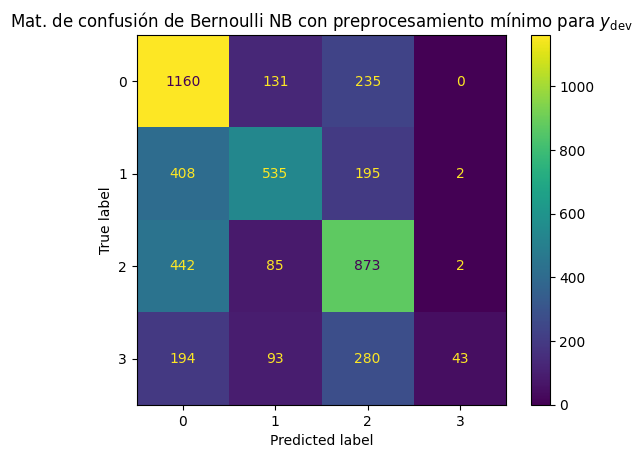

In [56]:
"""
- Con preprocesamiento mínimo
"""
bernoulli_nb = BernoulliNB()
bernoulli_nb.fit(dt_matrix_bin_train_min, y_train.ravel())
y_pred_bernoulli_min = bernoulli_nb.predict(dt_matrix_bin_dev_min)

ml_results["bernoulli_nb_min"] = get_metrics(y_dev, y_pred_bernoulli_min)

cm = confusion_matrix(y_dev, y_pred_bernoulli_min, labels=bernoulli_nb.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=bernoulli_nb.classes_)
disp.plot()
plt.title(r"Mat. de confusión de Bernoulli NB con preprocesamiento mínimo para $y_\text{dev}$")

save_model(bernoulli_nb, "bernoulli_nb_min")

ml_results["bernoulli_nb_min"] = get_metrics(y_dev, y_pred_bernoulli_min)

plt.show()

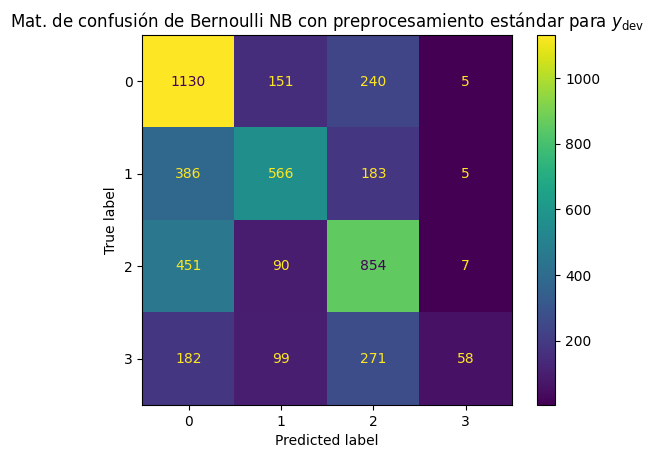

In [57]:
"""
- Con preprocesamiento estándar
"""
bernoulli_nb = BernoulliNB()
bernoulli_nb.fit(dt_matrix_bin_train_std, y_train.ravel())
y_pred_bernoulli_std = bernoulli_nb.predict(dt_matrix_bin_dev_std)

ml_results["bernoulli_nb_std"] = get_metrics(y_dev, y_pred_bernoulli_std)

cm = confusion_matrix(y_dev, y_pred_bernoulli_std, labels=bernoulli_nb.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=bernoulli_nb.classes_)
disp.plot()
plt.title(r"Mat. de confusión de Bernoulli NB con preprocesamiento estándar para $y_\text{dev}$")

save_model(bernoulli_nb, "bernoulli_nb_std")

ml_results["bernoulli_nb_std"] = get_metrics(y_dev, y_pred_bernoulli_std)

plt.show()

### Clasificador "Complement Naive Bayes"

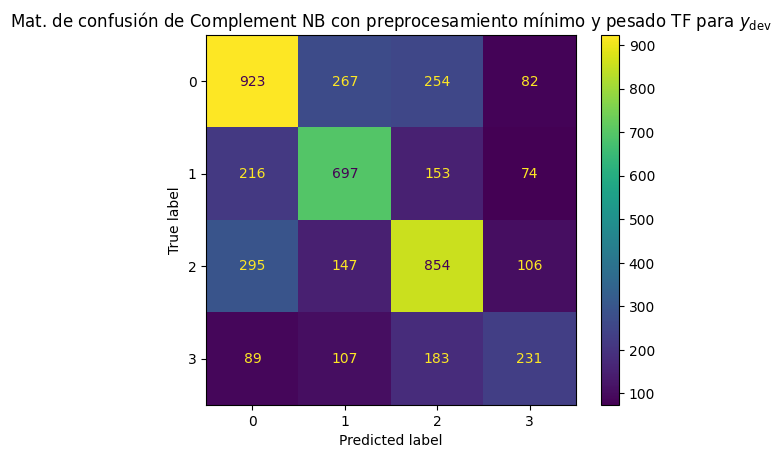

In [58]:
"""
- Con preprocesamiento mínimo y pesado TF
"""
complement_nb = ComplementNB()
complement_nb.fit(dt_matrix_tf_train_min, y_train.ravel())
y_pred_complementnb_tf_min = complement_nb.predict(dt_matrix_tf_dev_min)

ml_results["complement_nb_tf_min"] = get_metrics(y_dev, y_pred_complementnb_tf_min)

cm = confusion_matrix(y_dev, y_pred_complementnb_tf_min, labels=complement_nb.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=complement_nb.classes_)
disp.plot()
plt.title(r"Mat. de confusión de Complement NB con preprocesamiento mínimo y pesado TF para $y_\text{dev}$")

save_model(complement_nb, "complement_nb_tf_min")

ml_results["complement_nb_tf_min"] = get_metrics(y_dev, y_pred_complementnb_tf_min)

plt.show()

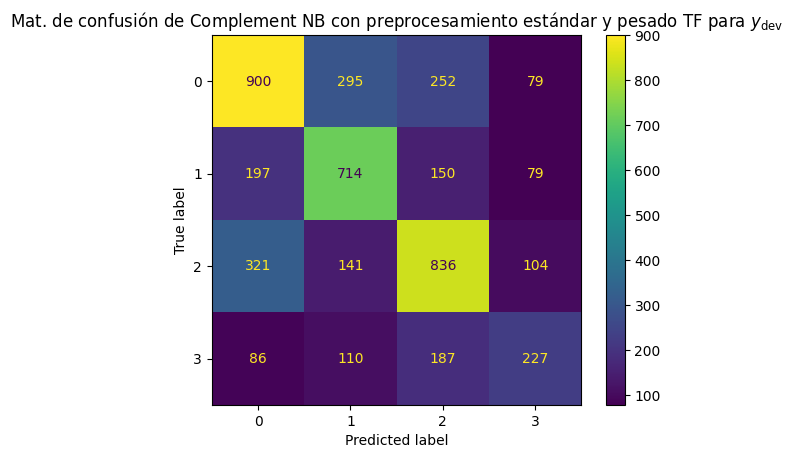

In [59]:
"""
- Con preprocesamiento estándar y pesado TF
"""
complement_nb = ComplementNB()
complement_nb.fit(dt_matrix_tf_train_std, y_train.ravel())
y_pred_complementnb_tf_std = complement_nb.predict(dt_matrix_tf_dev_std)

ml_results["complement_nb_tf_std"] = get_metrics(y_dev, y_pred_complementnb_tf_std)

cm = confusion_matrix(y_dev, y_pred_complementnb_tf_std, labels=complement_nb.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=complement_nb.classes_)
disp.plot()
plt.title(r"Mat. de confusión de Complement NB con preprocesamiento estándar y pesado TF para $y_\text{dev}$")

save_model(complement_nb, "complement_nb_tf_std")

ml_results["complement_nb_tf_std"] = get_metrics(y_dev, y_pred_complementnb_tf_std)

plt.show()

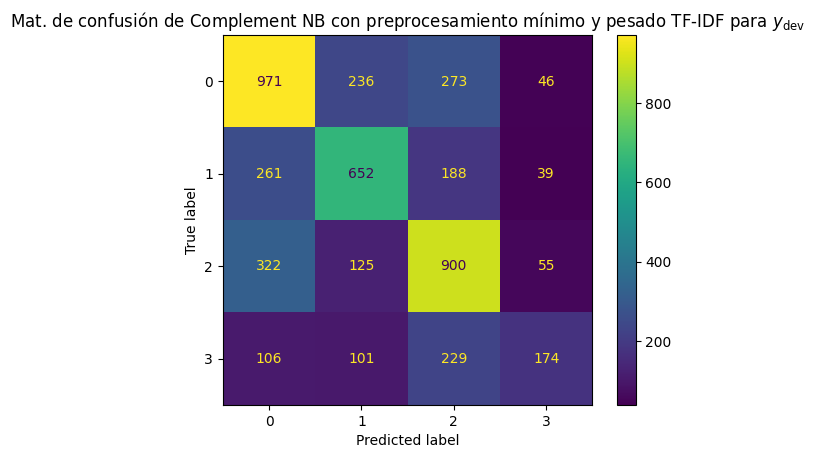

In [60]:
"""
- Con preprocesamiento mínimo y pesado TF-IDF
"""
complement_nb = ComplementNB()
complement_nb.fit(dt_matrix_tfidf_train_min, y_train.ravel())
y_pred_complementnb_tfidf_min = complement_nb.predict(dt_matrix_tfidf_dev_min)

ml_results["complement_nb_tfidf_min"] = get_metrics(y_dev, y_pred_complementnb_tfidf_min)

cm = confusion_matrix(y_dev, y_pred_complementnb_tfidf_min, labels=complement_nb.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=complement_nb.classes_)
disp.plot()
plt.title(r"Mat. de confusión de Complement NB con preprocesamiento mínimo y pesado TF-IDF para $y_\text{dev}$")

save_model(complement_nb, "complement_nb_tfidf_min")

ml_results["complement_nb_tfidf_min"] = get_metrics(y_dev, y_pred_complementnb_tfidf_min)

plt.show()

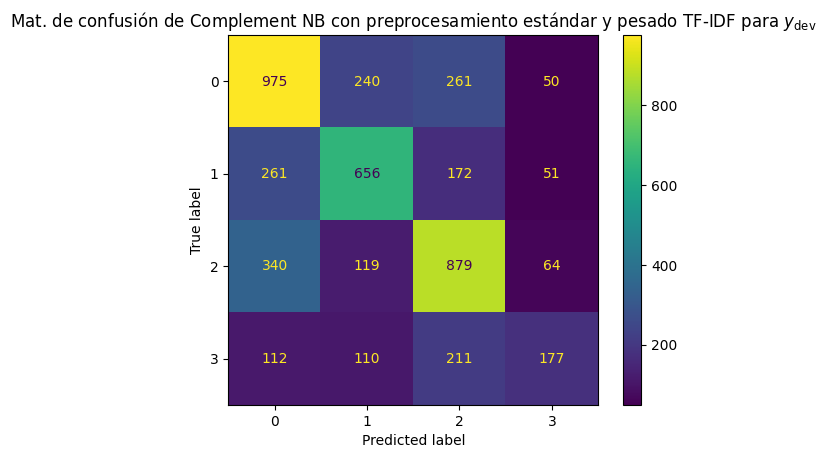

In [61]:
"""
- Con preprocesamiento estándar y pesado TF-IDF
"""
complement_nb = ComplementNB()
complement_nb.fit(dt_matrix_tfidf_train_std, y_train.ravel())
y_pred_complementnb_tfidf_std = complement_nb.predict(dt_matrix_tfidf_dev_std)

ml_results["complement_nb_tfidf_std"] = get_metrics(y_dev, y_pred_complementnb_tfidf_std)

cm = confusion_matrix(y_dev, y_pred_complementnb_tfidf_std, labels=complement_nb.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=complement_nb.classes_)
disp.plot()
plt.title(r"Mat. de confusión de Complement NB con preprocesamiento estándar y pesado TF-IDF para $y_\text{dev}$")

save_model(complement_nb, "complement_nb_tfidf_std")

ml_results["complement_nb_tfidf_std"] = get_metrics(y_dev, y_pred_complementnb_tfidf_std)

plt.show()

### Clasificador "Support Vector Machine"

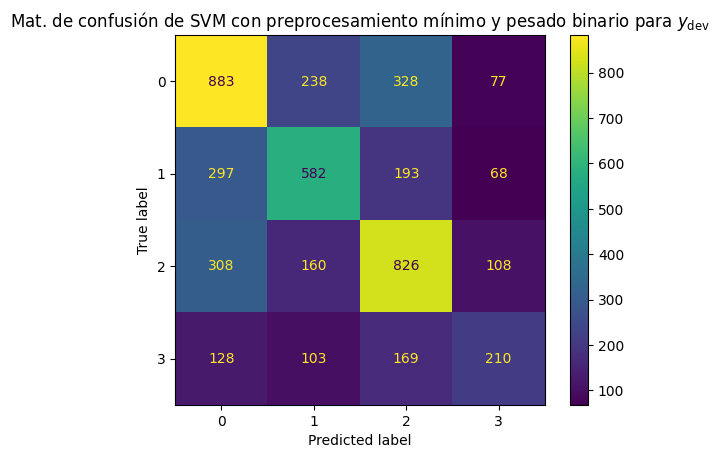

In [62]:
"""
- Con preprocesamiento mínimo y pesado binario
"""
svm = LinearSVC()
svm.fit(dt_matrix_bin_train_min, y_train.ravel())
y_pred_svm_bin_min = svm.predict(dt_matrix_bin_dev_min)

ml_results["svm_bin_min"] = get_metrics(y_dev, y_pred_svm_bin_min)

cm = confusion_matrix(y_dev, y_pred_svm_bin_min, labels=svm.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=svm.classes_)
disp.plot()
plt.title(r"Mat. de confusión de SVM con preprocesamiento mínimo y pesado binario para $y_\text{dev}$")

save_model(svm, "svm_bin_min")

ml_results["svm_bin_min"] = get_metrics(y_dev, y_pred_svm_bin_min)

plt.show()

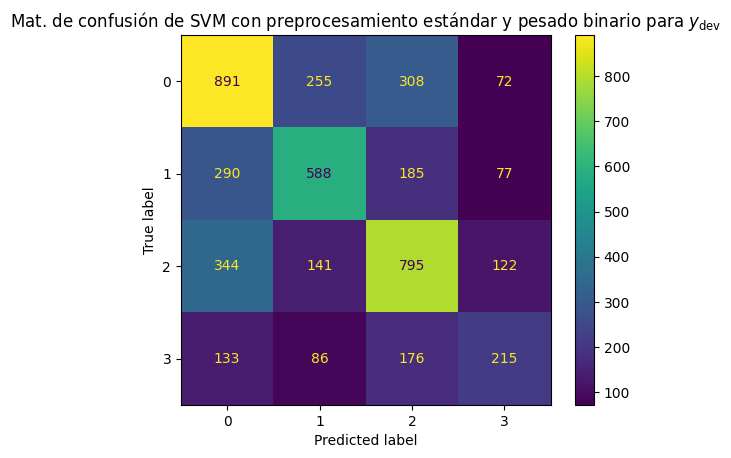

In [63]:
"""
- Con preprocesamiento estándar y pesado binario
"""
svm = LinearSVC()
svm.fit(dt_matrix_bin_train_std, y_train.ravel())
y_pred_svm_bin_std = svm.predict(dt_matrix_bin_dev_std)

ml_results["svm_bin_std"] = get_metrics(y_dev, y_pred_svm_bin_std)

cm = confusion_matrix(y_dev, y_pred_svm_bin_std, labels=svm.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=svm.classes_)
disp.plot()
plt.title(r"Mat. de confusión de SVM con preprocesamiento estándar y pesado binario para $y_\text{dev}$")

save_model(svm, "svm_bin_std")

ml_results["svm_bin_std"] = get_metrics(y_dev, y_pred_svm_bin_std)

plt.show()

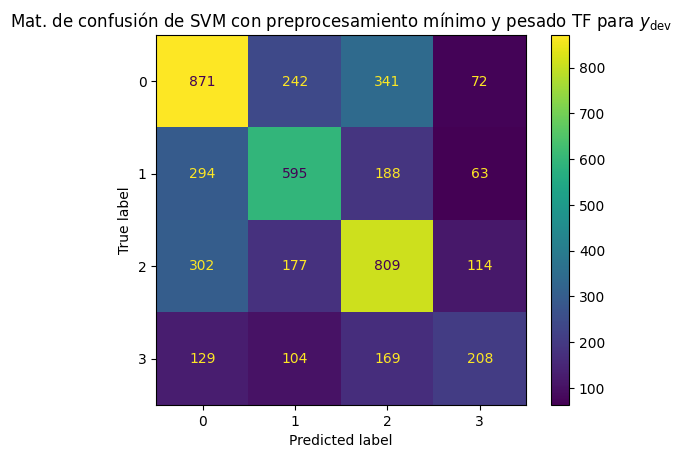

In [64]:
"""
- Con preprocesamiento mínimo y pesado TF
"""
svm = LinearSVC()
svm.fit(dt_matrix_tf_train_min, y_train.ravel())
y_pred_svm_tf_min = svm.predict(dt_matrix_tf_dev_min)

ml_results["svm_tf_min"] = get_metrics(y_dev, y_pred_svm_tf_min)

cm = confusion_matrix(y_dev, y_pred_svm_tf_min, labels=svm.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=svm.classes_)
disp.plot()
plt.title(r"Mat. de confusión de SVM con preprocesamiento mínimo y pesado TF para $y_\text{dev}$")

save_model(svm, "svm_tf_min")

ml_results["svm_tf_min"] = get_metrics(y_dev, y_pred_svm_tf_min)

plt.show()

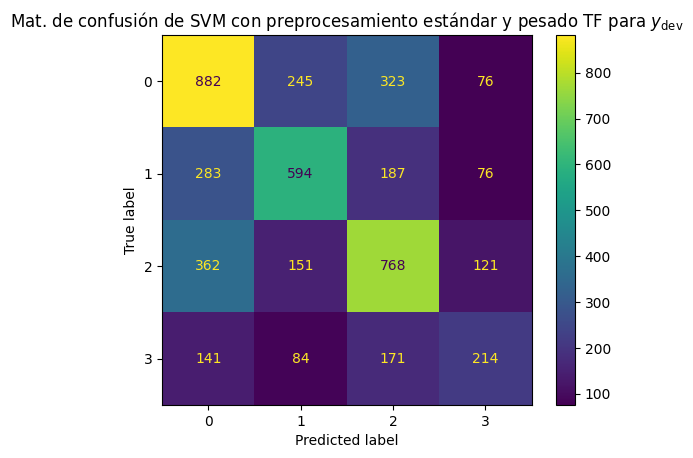

In [65]:
"""
- Con preprocesamiento estándar y pesado TF
"""
svm = LinearSVC()
svm.fit(dt_matrix_tf_train_std, y_train.ravel())
y_pred_svm_tf_std = svm.predict(dt_matrix_tf_dev_std)

ml_results["svm_tf_std"] = get_metrics(y_dev, y_pred_svm_tf_std)

cm = confusion_matrix(y_dev, y_pred_svm_tf_std, labels=svm.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=svm.classes_)
disp.plot()
plt.title(r"Mat. de confusión de SVM con preprocesamiento estándar y pesado TF para $y_\text{dev}$")

save_model(svm, "svm_tf_std")

ml_results["svm_tf_std"] = get_metrics(y_dev, y_pred_svm_tf_std)

plt.show()

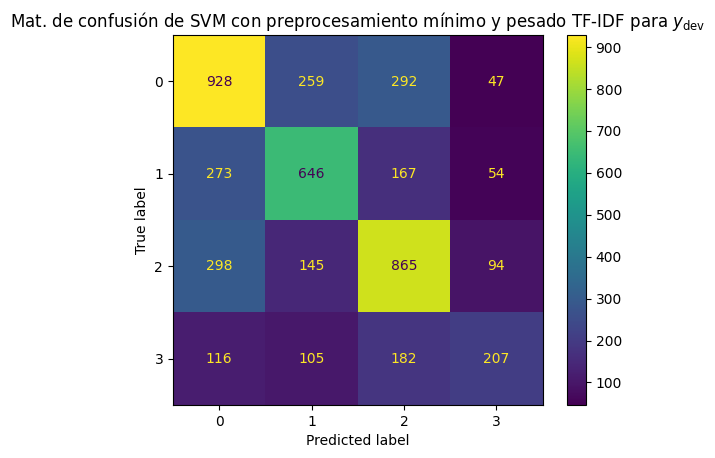

In [66]:
"""
- Con preprocesamiento mínimo y pesado TF-IDF
"""
svm = LinearSVC()
svm.fit(dt_matrix_tfidf_train_min, y_train.ravel())
y_pred_svm_tfidf_min = svm.predict(dt_matrix_tfidf_dev_min)

ml_results["svm_tfidf_min"] = get_metrics(y_dev, y_pred_svm_tfidf_min)

cm = confusion_matrix(y_dev, y_pred_svm_tfidf_min, labels=svm.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=svm.classes_)
disp.plot()
plt.title(r"Mat. de confusión de SVM con preprocesamiento mínimo y pesado TF-IDF para $y_\text{dev}$")

save_model(svm, "svm_tfidf_min")

ml_results["svm_tfidf_min"] = get_metrics(y_dev, y_pred_svm_tfidf_min)

plt.show()

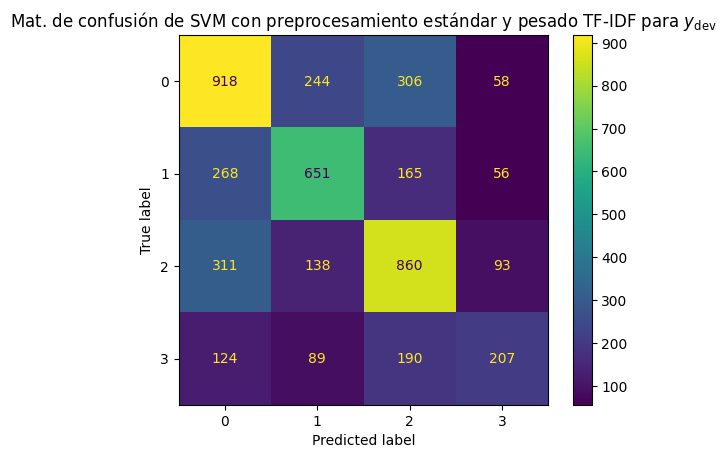

In [67]:
"""
- Con preprocesamiento estándar y pesado TF-IDF
"""
svm = LinearSVC()
svm.fit(dt_matrix_tfidf_train_std, y_train.ravel())
y_pred_svm_tfidf_std = svm.predict(dt_matrix_tfidf_dev_std)

ml_results["svm_tfidf_std"] = get_metrics(y_dev, y_pred_svm_tfidf_std)

cm = confusion_matrix(y_dev, y_pred_svm_tfidf_std, labels=svm.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=svm.classes_)
disp.plot()
plt.title(r"Mat. de confusión de SVM con preprocesamiento estándar y pesado TF-IDF para $y_\text{dev}$")

save_model(svm, "svm_tfidf_std")

ml_results["svm_tfidf_std"] = get_metrics(y_dev, y_pred_svm_tfidf_std)

plt.show()

In [68]:
print("- Resultados en algoritmos de ML clásicos:")
for model, metrics in ml_results.items():
    print(f"    - {model}:")
    for metric, value in metrics.items():
        print(f"        - {metric}: {value}")

- Resultados en algoritmos de ML clásicos:
    - bernoulli_nb_min:
        - accuracy: 0.5581445061992304
        - precision: 0.6566450463691542
        - recall: 0.48065730145892915
        - macro_f1: 0.4692802686906764
    - bernoulli_nb_std:
        - accuracy: 0.5575032064985036
        - precision: 0.6188907368180436
        - recall: 0.48530026097748696
        - macro_f1: 0.4791416963105966
    - complement_nb_tf_min:
        - accuracy: 0.5782385634886704
        - precision: 0.5595657196820396
        - recall: 0.5510177817684854
        - macro_f1: 0.5539053955724695
    - complement_nb_tf_std:
        - accuracy: 0.5722530996152202
        - precision: 0.5539875668972719
        - recall: 0.546128786283813
        - macro_f1: 0.54840047885067
    - complement_nb_tfidf_min:
        - accuracy: 0.5765284309533989
        - precision: 0.5725989746887213
        - recall: 0.5338549686755817
        - macro_f1: 0.5415741157080802
    - complement_nb_tfidf_std:
        - accurac

## Clasificación con modelos de Aprendizaje Profundo 🧠

In [69]:
# Comprobamos si los modelos se encuentran guardados
dl_models_saved = all([e in os.listdir(models_path) for e in ["dnn_static_min.keras",
                                                               "dnn_static_std.keras",
                                                               "cnn_static_min.keras",
                                                               "cnn_static_std.keras",
                                                              "dnn_fasttext_min.keras",
                                                              "dnn_fasttext_std.keras",
                                                              "cnn_fasttext_min.keras",
                                                              "cnn_fasttext_std.keras"]])

In [70]:
"""
- Convertimos los vectores de etiquetas en tensores one-hot
"""
y_train_tensor = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_dev_tensor = tf.keras.utils.to_categorical(y_dev, num_classes=4)

In [71]:
"""
- Función auxiliar para mostrar las gráficas de pérdida / epoch
"""
def plot_loss_for_epoch(history, model_name):
    plt.figure()
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title(f"Pérdida por epoch de {model_name}")
    plt.ylabel("Pérdida")
    plt.xlabel("Epoch")
    plt.legend(["Entrenamiento", "Validación"], loc="upper right")
    plt.show()

### Utilizando embeddings estáticos con inicialización aleatoria

In [72]:
from sklearn.decomposition import PCA
embeddings_static_train_std_pca = PCA(n_components=50).fit_transform(embeddings_static_train_std)
embeddings_static_dev_std_pca = PCA(n_components=50).fit_transform(embeddings_static_dev_std)

#### DNN

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2572 - loss: 773.8145 - val_accuracy: 0.2874 - val_loss: 78.5740
Epoch 2/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2836 - loss: 83.4067 - val_accuracy: 0.2840 - val_loss: 12.5023
Epoch 3/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2812 - loss: 12.6764 - val_accuracy: 0.3087 - val_loss: 4.3063
Epoch 4/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3012 - loss: 4.5035 - val_accuracy: 0.3141 - val_loss: 2.9348
Epoch 5/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2997 - loss: 2.9859 - val_accuracy: 0.3098 - val_loss: 2.3742
Epoch 6/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3026 - loss: 2.3100 - val_accuracy: 0.3109 - val_loss: 2.0443
Epoch 7/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3140 - loss: 1.9595 - val_accuracy: 0.3105 - val_loss: 1.8765
Epoch 8/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3105 - loss: 1.8292 - val_accura

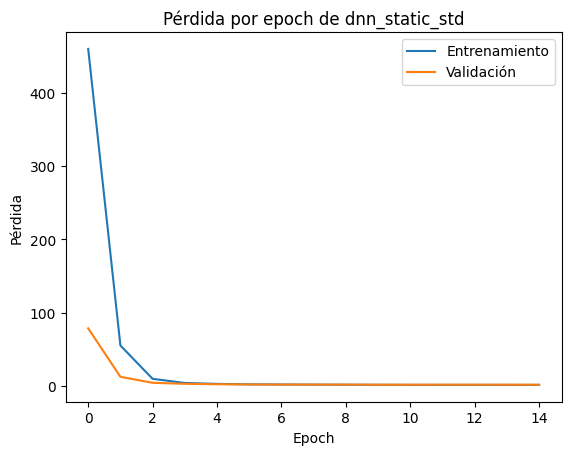

In [73]:
"""
- Con preprocesamiento mínimo + DNN
"""
if not dl_models_saved:
    embedding_dim = 100
    vocab_size = 15000
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(embeddings_static_train_min.shape[1],)))
    model.add(Dropout(0.4))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    history_dnn_static_min = model.fit(embeddings_static_train_min, y_train_tensor, epochs=15, batch_size=64, validation_split=0.2, verbose=True)

    plot_loss_for_epoch(history_dnn_static_std, "dnn_static_min")

    model.save(os.path.join(models_path, "dnn_static_min.keras"))

else:
    dnn_static_min = load_model(os.path.join(models_path, "dnn_static_min.keras"))



In [102]:
# === dnn_static_min ===
y_pred_probs = dnn_static_min.predict(embeddings_static_dev_std)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_dev_tensor, axis=1)

ml_results["dnn_static_min"] = get_metrics(y_true, y_pred)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Matriz de confusión - DNN (embedding aleatorio, mínimo)")
plt.grid(False)
plt.tight_layout()
plt.show()

for metric, value in ml_results["dnn_static_min"].items():
    print(f"{metric.capitalize()}: {value:.4f}")


NameError: name 'dnn_static_min' is not defined

Epoch 1/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.2952 - loss: 60.7317 - val_accuracy: 0.3308 - val_loss: 1.3503
Epoch 2/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3221 - loss: 1.3524 - val_accuracy: 0.3310 - val_loss: 1.3397
Epoch 3/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3255 - loss: 1.3348 - val_accuracy: 0.3310 - val_loss: 1.3381
Epoch 4/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.3259 - loss: 1.3339 - val_accuracy: 0.3310 - val_loss: 1.3388
Epoch 5/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3280 - loss: 1.3361 - val_accuracy: 0.3308 - val_loss: 1.3403
Epoch 6/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3272 - loss: 1.3368 - val_accuracy: 0.3308 - val_loss: 1.3376
Epoch 7/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.3219 - loss: 1.3483 - val_accuracy: 0.3308 - val_loss: 1.3376
Epoch 8/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3289 - loss: 1.3345 - val_accuracy: 0

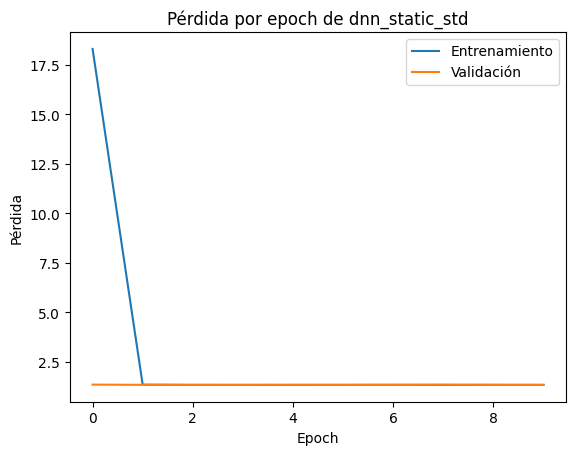

In [76]:
"""
- Con preprocesamiento estándar + DNN
"""
if not dl_models_saved:
    dnn_static_std = Sequential()
    #dnn_static_std.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
    dnn_static_std.add(Flatten())
    dnn_static_std.add(Dense(128, activation="relu"))
    dnn_static_std.add(Dense(64, activation="relu"))
    dnn_static_std.add(Dense(32, activation="relu"))
    dnn_static_std.add(Dense(4, activation="softmax"))

    dnn_static_std.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    history_dnn_static_std = dnn_static_std.fit(embeddings_static_train_std_pca, y_train_tensor, epochs=10, batch_size=32, validation_split=0.2, verbose=True)

    plot_loss_for_epoch(history_dnn_static_std, "dnn_static_std")

    dnn_static_std.save(os.path.join(models_path, "dnn_static_std.keras"))

else:
    dnn_static_std = load_model(os.path.join(models_path, "dnn_static_std.keras"))

147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


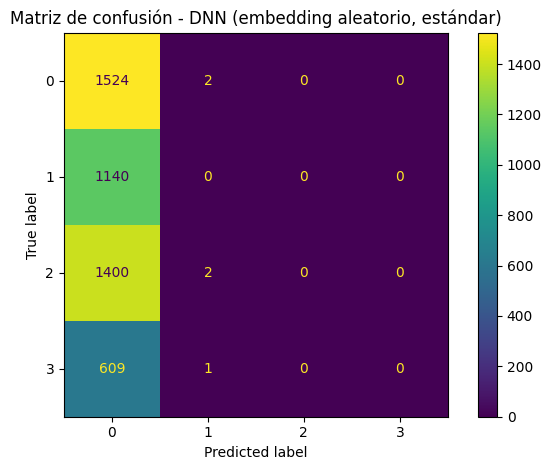

Accuracy: 0.3258
Precision: 0.0815
Recall: 0.2497
Macro_f1: 0.1229


In [77]:
y_pred_probs = dnn_static_std.predict(embeddings_static_dev_std_pca)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_dev_tensor, axis=1)

ml_results["dnn_static_std"] = get_metrics(y_true, y_pred)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Matriz de confusión - DNN (embedding aleatorio, estándar)")
plt.grid(False)
plt.tight_layout()
plt.show()

for metric, value in ml_results["dnn_static_std"].items():
    print(f"{metric.capitalize()}: {value:.4f}")


#### CNN

Epoch 1/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.3670 - loss: 1.3087 - val_accuracy: 0.4974 - val_loss: 1.1382
Epoch 2/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6304 - loss: 0.8918 - val_accuracy: 0.5373 - val_loss: 1.1125
Epoch 3/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8347 - loss: 0.4420 - val_accuracy: 0.5061 - val_loss: 1.4186
Epoch 4/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9454 - loss: 0.1580 - val_accuracy: 0.5249 - val_loss: 2.0321
Epoch 5/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9798 - loss: 0.0579 - val_accuracy: 0.5145 - val_loss: 2.9391
Epoch 6/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9878 - loss: 0.0376 - val_accuracy: 0.5197 - val_loss: 3.1112
Epoch 7/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9901 - loss: 0.0269 - val_accuracy: 0.5126 - val_loss: 3.8093
Epoch 8/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9904 - loss: 0.0304 - val_accuracy: 0

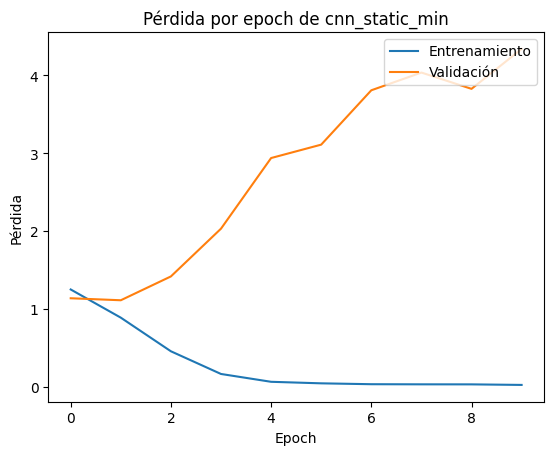

In [78]:
"""
- Con preprocesamiento mínimo + CNN
"""
if not dl_models_saved:
    cnn_static_min = Sequential()
    cnn_static_min.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
    cnn_static_min.add(Conv1D(128, (5,), activation="relu"))
    cnn_static_min.add(MaxPooling1D(2))
    cnn_static_min.add(Conv1D(64, (3,), activation="relu"))
    cnn_static_min.add(MaxPooling1D(2))
    cnn_static_min.add(Flatten())
    cnn_static_min.add(Dense(64, activation="relu"))
    cnn_static_min.add(Dense(32, activation="relu"))
    cnn_static_min.add(Dense(4, activation="softmax"))

    cnn_static_min.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    history_cnn_static_min = cnn_static_min.fit(embeddings_static_train_min, y_train_tensor, epochs=10, batch_size=32, validation_split=0.2, verbose=True)

    plot_loss_for_epoch(history_cnn_static_min, "cnn_static_min")

    cnn_static_min.save(os.path.join(models_path, "cnn_static_min.keras"))

else:
    cnn_static_min = load_model(os.path.join(models_path, "cnn_static_min.keras"))

147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


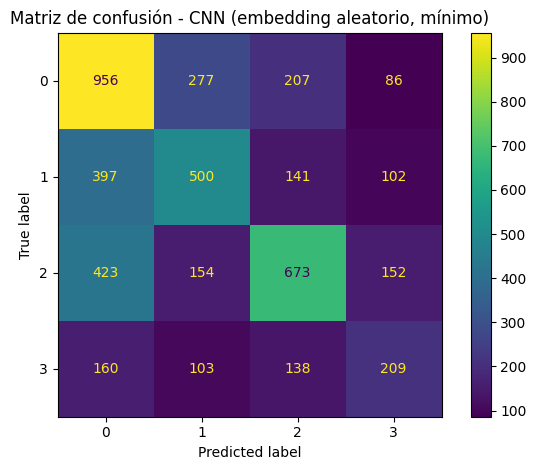

Accuracy: 0.4998
Precision: 0.4847
Recall: 0.4719
Macro_f1: 0.4746


In [79]:
# === cnn_static_min ===
y_pred_probs = cnn_static_min.predict(embeddings_static_dev_min)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_dev_tensor, axis=1)

ml_results["cnn_static_min"] = get_metrics(y_true, y_pred)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Matriz de confusión - CNN (embedding aleatorio, mínimo)")
plt.grid(False)
plt.tight_layout()
plt.show()

for metric, value in ml_results["cnn_static_min"].items():
    print(f"{metric.capitalize()}: {value:.4f}")


Epoch 1/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.3275 - loss: 1.3337 - val_accuracy: 0.4183 - val_loss: 1.2510
Epoch 2/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4715 - loss: 1.1674 - val_accuracy: 0.5049 - val_loss: 1.1635
Epoch 3/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6164 - loss: 0.9519 - val_accuracy: 0.5151 - val_loss: 1.1479
Epoch 4/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6983 - loss: 0.7632 - val_accuracy: 0.5184 - val_loss: 1.1970
Epoch 5/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7718 - loss: 0.5949 - val_accuracy: 0.5131 - val_loss: 1.3001
Epoch 6/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.8228 - loss: 0.4669 - val_accuracy: 0.5111 - val_loss: 1.5383
Epoch 7/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8650 - loss: 0.3613 - val_accuracy: 0.5090 - val_loss: 1.6829
Epoch 8/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8934 - loss: 0.2923 - val_accuracy

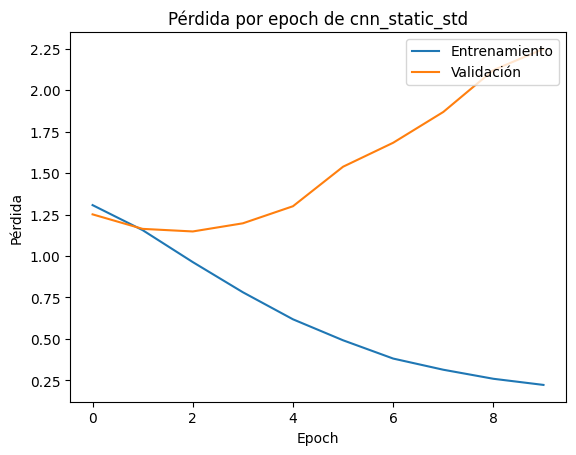

In [80]:
"""
- Con preprocesamiento estándar + CNN
"""
if not dl_models_saved:
    cnn_static_std = Sequential()
    cnn_static_std.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
    cnn_static_std.add(Conv1D(128, (5,), activation="relu"))
    cnn_static_std.add(MaxPooling1D(2))
    cnn_static_std.add(Dropout(0.5))
    cnn_static_std.add(Conv1D(16, (3,), activation="relu"))
    cnn_static_std.add(MaxPooling1D(2))
    cnn_static_std.add(Dropout(0.5))
    cnn_static_std.add(Flatten())
    cnn_static_std.add(Dense(64, activation="relu"))
    cnn_static_std.add(Dense(32, activation="relu"))
    cnn_static_std.add(Dense(4, activation="softmax"))

    cnn_static_std.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    history_cnn_static_std = cnn_static_std.fit(embeddings_static_train_std, y_train_tensor, epochs=10, batch_size=32, validation_split=0.2, verbose=True)

    plot_loss_for_epoch(history_cnn_static_std, "cnn_static_std")

    cnn_static_std.save(os.path.join(models_path, "cnn_static_std.keras"))

else:
    cnn_static_std = load_model(os.path.join(models_path, "cnn_static_std.keras"))

147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


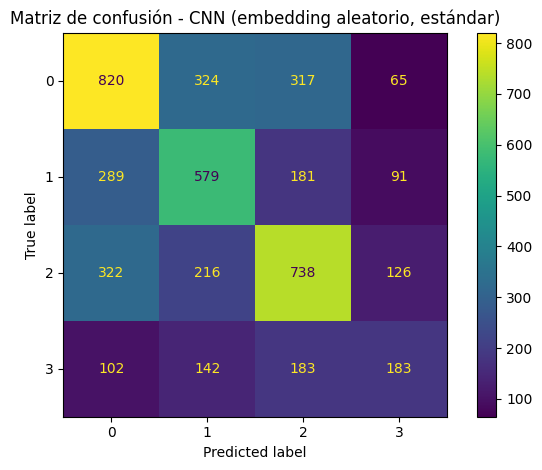

Accuracy: 0.4959
Precision: 0.4769
Recall: 0.4679
Macro_f1: 0.4705


In [81]:
# === cnn_static_std ===
y_pred_probs = cnn_static_std.predict(embeddings_static_dev_std)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_dev_tensor, axis=1)

ml_results["cnn_static_std"] = get_metrics(y_true, y_pred)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Matriz de confusión - CNN (embedding aleatorio, estándar)")
plt.grid(False)
plt.tight_layout()
plt.show()

for metric, value in ml_results["cnn_static_std"].items():
    print(f"{metric.capitalize()}: {value:.4f}")


### Utilizando embedding estático entrenado con FastText

#### DNN

In [82]:
embedding_dim = embedding_matrix_fasttext_min.shape[1]


Epoch 1/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3235 - loss: 1.3824 - val_accuracy: 0.3262 - val_loss: 1.3389
Epoch 2/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.3270 - loss: 1.3357 - val_accuracy: 0.3262 - val_loss: 1.3330
Epoch 3/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3375 - loss: 1.3279 - val_accuracy: 0.3350 - val_loss: 1.3072
Epoch 4/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3592 - loss: 1.3036 - val_accuracy: 0.3920 - val_loss: 1.2905
Epoch 5/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4054 - loss: 1.2631 - val_accuracy: 0.4277 - val_loss: 1.2597
Epoch 6/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4814 - loss: 1.2042 - val_accuracy: 0.4788 - val_loss: 1.2092
Epoch 7/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5250 - loss: 1.1531 - val_accuracy: 0.4690 - val_loss: 1.1980
Epoch 8/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5295 - loss: 1.1264 - val_accuracy: 0.

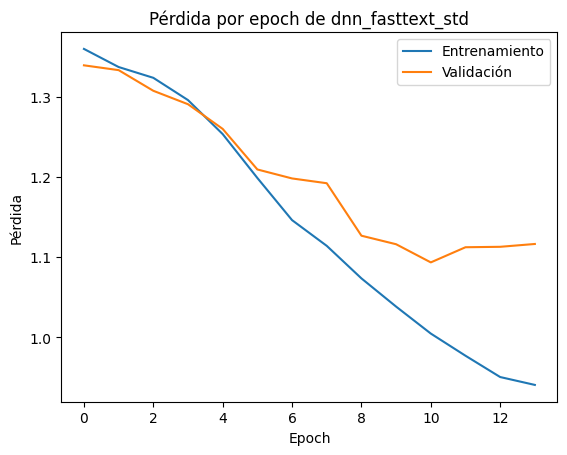

In [83]:
"""
- Con preprocesamiento estándar + DNN
"""


if not dl_models_saved:

    dnn_fasttext_std = Sequential()
    dnn_fasttext_std.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix_fasttext_std],
        trainable=True
    ))
    dnn_fasttext_std.add(GlobalAveragePooling1D())
    dnn_fasttext_std.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    dnn_fasttext_std.add(Dropout(0.5))
    dnn_fasttext_std.add(Dense(4, activation='softmax'))

    dnn_fasttext_std.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history_dnn_fasttext_std = dnn_fasttext_std.fit(
        embeddings_fasttext_train_std,
        y_train_tensor,
        validation_data=(embeddings_fasttext_dev_std, y_dev_tensor),
        batch_size=64,
        epochs=15,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
        verbose=True
    )

    plot_loss_for_epoch(history_dnn_fasttext_std, "dnn_fasttext_std")
    dnn_fasttext_std.save(os.path.join(models_path, "dnn_fasttext_std.keras"))
else:
    dnn_fasttext_std = load_model(os.path.join(models_path, "dnn_fasttext_std.keras"))



147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.5400
Precision: 0.5222
Recall: 0.4724
Macro_f1: 0.4559


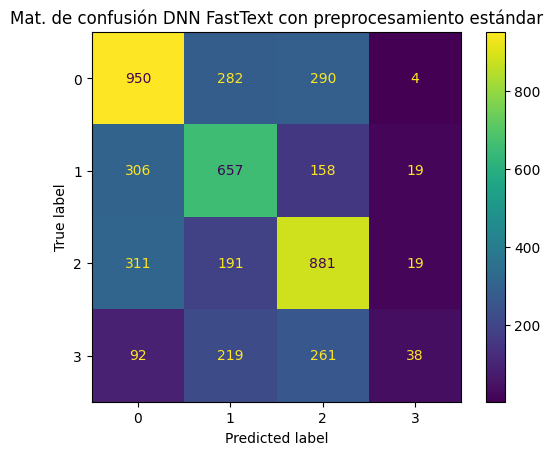

In [101]:
# === Predicciones ===
y_pred_probs = dnn_fasttext_std.predict(embeddings_fasttext_dev_std)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_dev_tensor, axis=1)

# === Guardar métricas ===
ml_results["dnn_fasttext_std"] = get_metrics(y_true, y_pred)

# === Mostrar métricas ===
for metric, value in ml_results["dnn_fasttext_std"].items():
    print(f"{metric.capitalize()}: {value:.4f}")

# === Matriz de confusión ===
cm = confusion_matrix(y_dev, y_pred, labels=complement_nb.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=complement_nb.classes_)
disp.plot()
plt.title(r"Mat. de confusión DNN FastText con preprocesamiento estándar")

# === Guardar modelo ===
save_model(dnn_fasttext_std, "dnn_fasttext_std")


#### CNN

Epoch 1/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.3809 - loss: 1.2967 - val_accuracy: 0.5188 - val_loss: 1.0999
Epoch 2/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.6190 - loss: 0.9320 - val_accuracy: 0.5759 - val_loss: 1.0395
Epoch 3/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7648 - loss: 0.6140 - val_accuracy: 0.5564 - val_loss: 1.2218
Epoch 4/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8895 - loss: 0.3186 - val_accuracy: 0.5517 - val_loss: 1.6662
Epoch 5/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9502 - loss: 0.1541 - val_accuracy: 0.5306 - val_loss: 2.1615


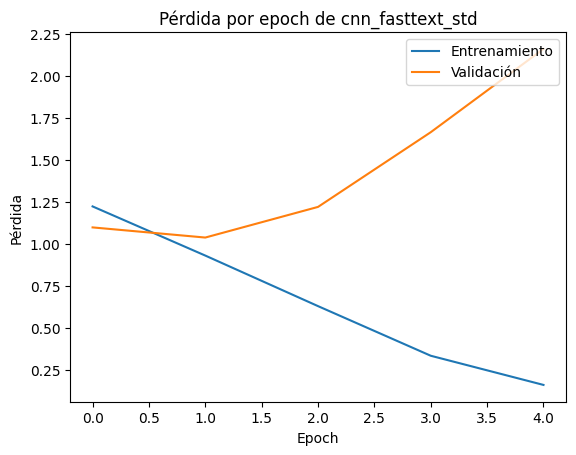

147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.5759
Precision: 0.5721
Recall: 0.5346
Macro_f1: 0.5429


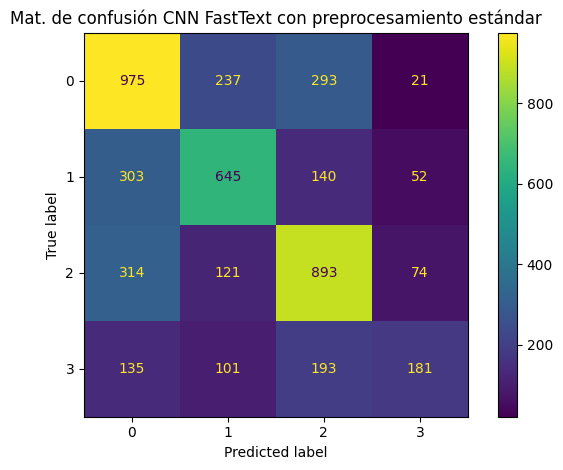

In [92]:
"""
- Con preprocesamiento estándar + CNN (FastText)
"""

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

if not dl_models_saved:
    cnn_fasttext_std = Sequential()
    cnn_fasttext_std.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix_fasttext_std],
        trainable=True
    ))
    cnn_fasttext_std.add(Conv1D(128, kernel_size=5, activation='relu'))
    cnn_fasttext_std.add(MaxPooling1D(pool_size=2))
    cnn_fasttext_std.add(Conv1D(64, kernel_size=3, activation='relu'))
    cnn_fasttext_std.add(MaxPooling1D(pool_size=2))
    cnn_fasttext_std.add(Flatten())
    cnn_fasttext_std.add(Dense(64, activation='relu'))
    cnn_fasttext_std.add(Dropout(0.5))
    cnn_fasttext_std.add(Dense(4, activation='softmax'))

    cnn_fasttext_std.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history_cnn_fasttext_std = cnn_fasttext_std.fit(
        embeddings_fasttext_train_std,
        y_train_tensor,
        validation_data=(embeddings_fasttext_dev_std, y_dev_tensor),
        batch_size=64,
        epochs=15,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
        verbose=True
    )

    plot_loss_for_epoch(history_cnn_fasttext_std, "cnn_fasttext_std")
    cnn_fasttext_std.save(os.path.join(models_path, "cnn_fasttext_std.keras"))
else:
    cnn_fasttext_std = load_model(os.path.join(models_path, "cnn_fasttext_std.keras"))

y_pred_probs = cnn_fasttext_std.predict(embeddings_fasttext_dev_std)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_dev_tensor, axis=1)

ml_results["cnn_fasttext_std"] = get_metrics(y_true, y_pred)

for metric, value in ml_results["cnn_fasttext_std"].items():
    print(f"{metric.capitalize()}: {value:.4f}")

cm = confusion_matrix(y_dev, y_pred, labels=complement_nb.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=complement_nb.classes_)
disp.plot()
plt.title(r"Mat. de confusión CNN FastText con preprocesamiento estándar")
plt.grid(False)
plt.tight_layout()
plt.show()

save_model(cnn_fasttext_std, "cnn_fasttext_std")


#### LSTM

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.4052 - loss: 1.3250 - val_accuracy: 0.3053 - val_loss: 1.5195
Epoch 2/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.6582 - loss: 0.8953 - val_accuracy: 0.2946 - val_loss: 1.7113
Epoch 3/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.7787 - loss: 0.6317 - val_accuracy: 0.2978 - val_loss: 2.0180
Epoch 4/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.8511 - loss: 0.4436 - val_accuracy: 0.2871 - val_loss: 2.3887


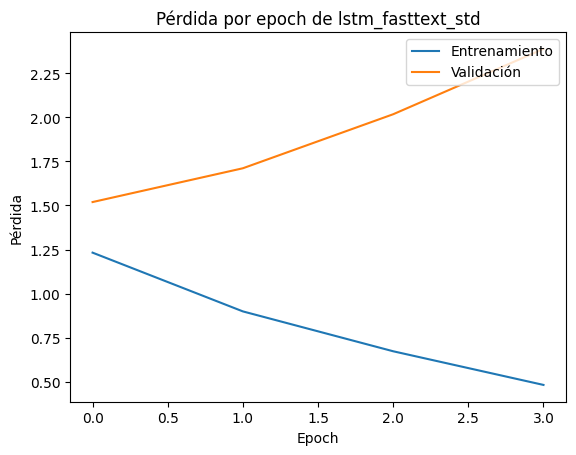

In [95]:
"""
- Con preprocesamiento mínimo + LSTM
"""
embedding_dim = 300

from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

if not dl_models_saved:

    lstm_fasttext_std = Sequential()
    lstm_fasttext_std.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix_fasttext_min],
        input_length=max_length,
        trainable=True
    ))
    lstm_fasttext_std.add(Bidirectional(LSTM(64)))
    lstm_fasttext_std.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    lstm_fasttext_std.add(Dropout(0.5))
    lstm_fasttext_std.add(Dense(4, activation='softmax'))

    lstm_fasttext_std.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history_lstm_fasttext_std = lstm_fasttext_std.fit(
        embeddings_fasttext_train_std,
        y_train_tensor,
        validation_data=(embeddings_fasttext_dev_min, y_dev_tensor),
        batch_size=64,
        epochs=15,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
        verbose=True
    )

    plot_loss_for_epoch(history_lstm_fasttext_std, "lstm_fasttext_std")
    lstm_fasttext_std.save(os.path.join(models_path, "lstm_fasttext_std.keras"))

else:
    lstm_fasttext_std = load_model(os.path.join(models_path, "lstm_fasttext_std.keras"))


147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


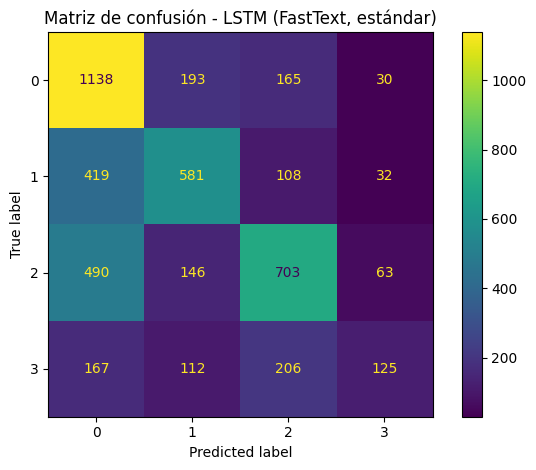

Accuracy: 0.5445
Precision: 0.5429
Recall: 0.4904
Macro_f1: 0.4946


In [98]:
y_pred_probs = lstm_fasttext_std.predict(embeddings_fasttext_dev_std)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_dev_tensor, axis=1)

ml_results["lstm_fasttext_std"] = get_metrics(y_true, y_pred)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Matriz de confusión - LSTM (FastText, estándar)")
plt.grid(False)
plt.tight_layout()
plt.show()

for metric, value in ml_results["lstm_fasttext_std"].items():
    print(f"{metric.capitalize()}: {value:.4f}")


# Predicción Test

In [96]:
label_decoder = {
    0: "moderate_left",
    1: "left",
    2: "moderate_right",
    3: "right"
}

In [97]:
"""
- Preprocesamiento estándar (tokens lematizados en minúsculas de longitud mayor o igual a 3, sin menciones,
URLs, puntuación ni stopwords)
"""
corpus_test_std = [" ".join(preprocess_sent(nlp, text,
                                remove_numbers=True,
                                lemmatize=True)) for text in corpus_test]

vectorizer_tfidf = TfidfVectorizer()
dt_matrix_tfidf_train_std = vectorizer_tfidf.fit_transform(corpus_train_std)
dt_matrix_tfidf_test_std = vectorizer_tfidf.transform(corpus_dev_std)

svm = LinearSVC()
svm.fit(dt_matrix_tf_train_std, y_train.ravel())
y_pred_svm_tf_std = svm.predict(dt_matrix_tfidf_test_std)

decoded_predictions = [label_decoder[pred] for pred in y_pred_svm_tf_std]

df_output = pd.DataFrame({
    "id": range(len(decoded_predictions)),
    "prediction": decoded_predictions
})

#Guardamos en .csv
df_output.to_csv("TestPrediction.csv", index=False)



#Embeddings contextuales

In [ ]:
import gc
import tensorflow as tf

def get_embeddings_in_batches(corpus, tokenizer, model, batch_size=4, max_length=64, use_cpu=True):
    embeddings = []
    for i in range(0, len(corpus), batch_size):
        batch = corpus[i:i + batch_size]
        encoded = tokenizer(batch, padding=True, truncation=True, return_tensors="tf", max_length=max_length)
        if use_cpu:
            with tf.device('/CPU:0'):
                output = model(encoded)[0]  # last_hidden_state
        else:
            output = model(encoded)[0]
        embeddings.append(output)
    return tf.concat(embeddings, axis=0)


In [ ]:
# Comprobamos si los embeddings contextuales están guardados
embeddings_context_saved = all([e in os.listdir(embeddings_context_path) for e in ["embeddings_context_train_min.pkl",
                                                                                   "embeddings_context_dev_min.pkl",
                                                                                   "embeddings_context_train_std.pkl",
                                                                                   "embeddings_context_dev_std.pkl"]])

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
transformer_model = TFAutoModel.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

In [ ]:
if not embeddings_context_saved:
    print("- Construyendo matrices de embeddings contextuales...")

    batch_size = 16

    """
    - Con preprocesamiento mínimo
    """
    embeddings_context_train_min_list = []
    for i in range(0, len(corpus_train_min), batch_size):
        batch = corpus_train_min[i:i + batch_size]
        encoded_inputs_train_min_batch = tokenizer(batch,
                                                  padding=True,
                                                  truncation=True,
                                                  return_tensors="tf",
                                                  max_length=128)
        # Access the last_hidden_state output, which is the first element of the tuple
        embeddings_context_train_min_list.append(transformer_model(encoded_inputs_train_min_batch)[0])

    embeddings_context_train_min = tf.concat(embeddings_context_train_min_list, axis=0)

    embeddings_context_dev_min_list = []
    for i in range(0, len(corpus_dev_min), batch_size):
        batch = corpus_dev_min[i:i + batch_size]
        encoded_inputs_dev_min_batch = tokenizer(batch,
                                                padding=True,
                                                truncation=True,
                                                return_tensors="tf",
                                                max_length=128)
        # Access the last_hidden_state output, which is the first element of the tuple
        embeddings_context_dev_min_list.append(transformer_model(encoded_inputs_dev_min_batch)[0])

    embeddings_context_dev_min = tf.concat(embeddings_context_dev_min_list, axis=0)

    with open(os.path.join(embeddings_context_path, "embeddings_context_train_min.pkl"), "wb") as f:
        pickle.dump(embeddings_context_train_min, f)

    with open(os.path.join(embeddings_context_path, "embeddings_context_dev_min.pkl"), "wb") as f:
        pickle.dump(embeddings_context_dev_min, f)

    """
    - Con preprocesamiento estándar
    """
    embeddings_context_train_std_list = []
    for i in range(0, len(corpus_train_std), batch_size):
        batch = corpus_train_std[i:i + batch_size]
        encoded_inputs_train_std_batch = tokenizer(batch,
                                                  padding=True,
                                                  truncation=True,
                                                  return_tensors="tf",
                                                  max_length=128)
        # Access the last_hidden_state output, which is the first element of the tuple
        embeddings_context_train_std_list.append(transformer_model(encoded_inputs_train_std_batch)[0])

    embeddings_context_train_std = tf.concat(embeddings_context_train_std_list, axis=0)

    embeddings_context_dev_std_list = []
    for i in range(0, len(corpus_dev_std), batch_size):
        batch = corpus_dev_std[i:i + batch_size]
        encoded_inputs_dev_std_batch = tokenizer(batch,
                                                padding=True,
                                                truncation=True,
                                                return_tensors="tf",
                                                max_length=128)
        # Access the last_hidden_state output, which is the first element of the tuple
        embeddings_context_dev_std_list.append(transformer_model(encoded_inputs_dev_std_batch)[0])

    embeddings_context_dev_std = tf.concat(embeddings_context_dev_std_list, axis=0)

    with open(os.path.join(embeddings_context_path, "embeddings_context_train_std.pkl"), "wb") as f:
        pickle.dump(embeddings_context_train_std, f)

    with open(os.path.join(embeddings_context_path, "embeddings_context_dev_std.pkl"), "wb") as f:
        pickle.dump(embeddings_context_dev_std, f)

else:
    print(f"Se han detectado los embeddings contextuales en {embeddings_context_path}.")
    with open(os.path.join(embeddings_context_path, "embeddings_context_train_min.pkl"), "rb") as f:
        embeddings_context_train_min = pickle.load(f)

    with open(os.path.join(embeddings_context_path, "embeddings_context_dev_min.pkl"), "rb") as f:
        embeddings_context_dev_min = pickle.load(f)

    with open(os.path.join(embeddings_context_path, "embeddings_context_train_std.pkl"), "rb") as f:
        embeddings_context_train_std = pickle.load(f)

    with open(os.path.join(embeddings_context_path, "embeddings_context_dev_std.pkl"), "rb") as f:
        embeddings_context_dev_std = pickle.load(f)

In [ ]:
"""
- Con preprocesamiento mínimo + DNN
"""
if not dl_models_saved:
    sequence_length = encoded_inputs_train_min.shape[1]
    embedding_dim = embeddings_context_train_min[0].shape[-1]

    dnn_context_min = Sequential()
    dnn_context_min.add(Input(shape=(sequence_length, embedding_dim)))
    dnn_context_min.add(Flatten())
    dnn_context_min.add(Dense(128, activation="relu"))
    dnn_context_min.add(Dense(64, activation="relu"))
    dnn_context_min.add(Dense(32, activation="relu"))
    dnn_context_min.add(Dense(4, activation="softmax"))

    dnn_context_min.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    history_dnn_context_min = dnn_context_min.fit(embeddings_context_train_min, y_train_tensor, epochs=10, batch_size=32, validation_split=0.2, verbose=True)

    plot_loss_for_epoch(history_dnn_context_min, "dnn_context_min")

    dnn_context_min.save(os.path.join(models_path, "dnn_context_min.keras"))

else:
    dnn_context_min = load_model(os.path.join(models_path, "dnn_context_min.keras"))

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(embeddings_static_train_std, y_train_tensor, epochs=10, batch_size=32, validation_split=0.2, verbose=True)

In [ ]:
"""
- Con preprocesamiento estándar + DNN
"""
if not dl_models_saved:
    sequence_length = encoded_inputs_train_std.shape[1]
    embedding_dim = embeddings_context_train_std[0].shape[-1]

    dnn_context_std = Sequential()
    dnn_context_std.add(Input(shape=(sequence_length, embedding_dim)))
    dnn_context_std.add(Flatten())
    dnn_context_std.add(Dense(128, activation="relu"))
    dnn_context_std.add(Dense(64, activation="relu"))
    dnn_context_std.add(Dense(32, activation="relu"))
    dnn_context_std.add(Dense(4, activation="softmax"))

    dnn_context_std.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    history_dnn_context_std = dnn_context_std.fit(embeddings_context_train_std, y_train_tensor, epochs=10, batch_size=32, validation_split=0.2, verbose=True)

    plot_loss_for_epoch(history_dnn_context_std, "dnn_context_std")

    dnn_context_std.save(os.path.join(models_path, "dnn_context_std.keras"))

else:
    dnn_context_std = load_model(os.path.join(models_path, "dnn_context_std.keras"))

In [ ]:
"""
- Con preprocesamiento mínimo + CNN
"""
if not dl_models_saved:
    sequence_length = encoded_inputs_train_min.shape[1]
    embedding_dim = embeddings_context_train_min[0].shape[-1]

    cnn_context_min = Sequential()
    cnn_context_min.add(Input(shape=(sequence_length, embedding_dim)))
    cnn_context_min.add(Flatten())
    cnn_context_min.add(Conv1D(128, (5,), activation="relu"))
    cnn_context_min.add(MaxPooling1D(2))
    cnn_context_min.add(Conv1D(64, (3,), activation="relu"))
    cnn_context_min.add(MaxPooling1D(2))
    cnn_context_min.add(Flatten())
    cnn_context_min.add(Dense(64, activation="relu"))
    cnn_context_min.add(Dense(32, activation="relu"))
    cnn_context_min.add(Dense(4, activation="softmax"))

    cnn_context_min.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    history_cnn_context_min = cnn_context_min.fit(embeddings_context_train_min, y_train_tensor, epochs=10, batch_size=32, validation_split=0.2, verbose=True)

    plot_loss_for_epoch(history_cnn_context_min, "cnn_context_min")

    cnn_context_min.save(os.path.join(models_path, "cnn_context_min.keras"))

else:
    cnn_context_min = load_model(os.path.join(models_path, "cnn_context_min.keras"))

In [ ]:
"""
- Con preprocesamiento estándar + CNN
"""
if not dl_models_saved:
    sequence_length = encoded_inputs_train_std.shape[1]
    embedding_dim = embeddings_context_train_std[0].shape[-1]

    cnn_context_std = Sequential()
    cnn_context_std.add(Input(shape=(sequence_length, embedding_dim)))
    cnn_context_std.add(Flatten())
    cnn_context_std.add(Conv1D(128, (5,), activation="relu"))
    cnn_context_std.add(MaxPooling1D(2))
    cnn_context_std.add(Conv1D(64, (3,), activation="relu"))
    cnn_context_std.add(MaxPooling1D(2))
    cnn_context_std.add(Flatten())
    cnn_context_std.add(Dense(64, activation="relu"))
    cnn_context_std.add(Dense(32, activation="relu"))
    cnn_context_std.add(Dense(4, activation="softmax"))

    cnn_context_std.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    history_cnn_context_std = cnn_context_std.fit(embeddings_context_train_std, y_train_tensor, epochs=10, batch_size=32, validation_split=0.2, verbose=True)

    plot_loss_for_epoch(history_cnn_context_std, "cnn_context_std")

    cnn_context_std.save(os.path.join(models_path, "cnn_context_std.keras"))

else:
    cnn_context_std = load_model(os.path.join(models_path, "cnn_context_std.keras"))